In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
from tqdm import tqdm
from numba import jit, njit, prange, cuda
from PIL import Image
import pandas as pd
from yaml import safe_load

In [3]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from scipy.sparse import csr_matrix
import pickle
import pandas as pd

# Functions

In [169]:
@njit(nogil=True)
def norm(x_i, x_j):
    return np.sum((x_i-x_j)**2)

@njit(nogil=True)
def QUBO_matr(img):
    """
    Find QUBO matrix  for omage recognition
    img - RGB of image pixels 
    """
    h, v, c = img.shape
    N = h*v
    x = img.reshape((N, c))/255
    qubo = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
                qubo[i, i] -= norm(x[i], x[j])
                qubo[i, j] = norm(x[i], x[j])
    return qubo
@njit(nogil=True)
def QUBO_matr_sparse(img, K = 1):
    """
    Find QUBO matrix  for omage recognition
    img - RGB of image pixels
    """
    h, v, c = img.shape
    N = h*v
    x = img.reshape((N, c))/255
    qubo = np.zeros((N, N))
    for i in range(h):
        for j in range(v):
            for k in range(-K, K+1):
                for l in range(-K, K+1):
                    if k != 0 or l !=0:
                        if i + k >= 0 and i + k < h and j + l >= 0 and j + l < v and k**2 + l**2 <= K:
                            flat_ij = i*v+j
                            flat_neigh = (i+k)*v+j+l
                            norm_neigh = norm(x[flat_ij], x[flat_neigh])
                            #print(i, j, k, l, norm_neigh)
                            qubo[flat_ij, flat_ij] -= norm_neigh
                            qubo[flat_neigh, flat_neigh] -= norm_neigh
                            qubo[flat_ij, flat_neigh] += norm_neigh
                            qubo[flat_neigh, flat_ij] += norm_neigh
    return qubo


@njit(nogil=True)
def QUBO_matr_full(img, K1, K2, B, decay = False):
    """
    Find QUBO matrix  for omage recognition
    img - RGB of image pixels 
    K1 - K1 nearest neighbours 
    """
    h, v, c = img.shape
    N = h*v
    x = img.reshape((N, c))/255
    qubo = np.zeros((N, N))
    for i in range(h):
        for j in range(v):
            for k in range(-K1, K1+1):
                for l in range(-K1, K1+1):
                    if k != 0 or l !=0:
                        kl_square = k**2 + l**2
                        if i + k >= 0 and i + k < h and j + l >= 0 and j + l < v and kl_square <= K1**2:                                
                            flat_ij = i*v+j
                            flat_neigh = (i+k)*v+j+l
                            if decay:
                                norm_neigh = norm(x[flat_ij], x[flat_neigh])/kl_square
                            else:
                                norm_neigh = norm(x[flat_ij], x[flat_neigh]) 
                            if kl_square <= K2**2:
                                qubo[flat_ij, flat_ij] += B
                                qubo[flat_neigh, flat_neigh] += B                          
                            #print(i, j, k, l, norm_neigh)
                            qubo[flat_ij, flat_ij] -= norm_neigh
                            qubo[flat_neigh, flat_neigh] -= norm_neigh
                            qubo[flat_ij, flat_neigh] += norm_neigh
                            qubo[flat_neigh, flat_ij] += norm_neigh
    return qubo

def qboard_problem(problem_id, problem_type, task_number, matrix_file, where = 'MIN'):
    obj_aux = dict(to = where, filenames = matrix_file)
    return dict(id = problem_id, type = problem_type, 
                data_dir = '~/task_' + str(task_number) + '/pkl',
                #data_dir = '~/pkl',
                objective = obj_aux)
def compile_yaml(all_problems, output_file):
    output = []
    for problem in all_problems:
        output.append(qboard_problem(*problem))
    stream = open(output_file, 'w')
    yaml.dump(dict(problems = output), stream, sort_keys = False)
    stream.close()
    return

def make_pkl(matrix, filename):
    stream = open(filename, 'wb')
    pickle.dump(csr_matrix(matrix), stream)
    stream.close()
    return


# Test

In [5]:
ion = cv2.imread("ions/2fe6e651-1efb-4ae0-ae94-88fbaa4919d9.png")

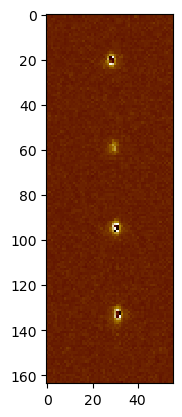

In [6]:
plt.imshow(ion, interpolation='nearest')
plt.show()

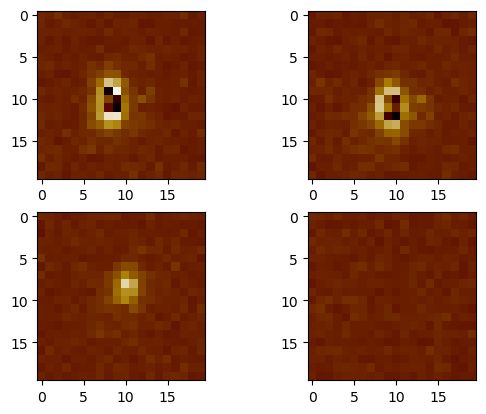

In [147]:
folder = "ions"

ion_list = []
problems = []

fig, ax = plt.subplots(2,2)
ax = ax.flatten()

ion = cv2.imread('ions/1e59fefb-6b32-4b6a-b16d-9e66e2c820dd.png', cv2.COLOR_BGR2GRAY)
    # plt.imshow(ion, interpolation='nearest')
    # plt.show()
    # tmp = []
for j in range(4):
    el = ion[10+38*j:30+38*j, 20:40, :]
    ax[j].imshow(el)

# for i,_ in enumerate(os.listdir(folder)):
#     ion = cv2.imread(folder+"/"+os.listdir(folder)[i])
#     # plt.imshow(ion, interpolation='nearest')
#     # plt.show()
#     # tmp = []
#     for j in range(4):
#         ax[j].imshow(ion[10+38*j:30+38*j, 22:36, :])

# Image prep

In [58]:
from scipy.sparse import csr_matrix

In [206]:
folder = "ions_full"

ion_list = []
problems = []
for i, f in enumerate(os.listdir(folder)[50:150]):
    ion = cv2.imread(folder+"/"+f)
    l = i + 50
    # print(folder+"/"+os.listdir(folder)[i])
    # plt.imshow(ion, interpolation='nearest')
    # plt.show()
    # fig, ax = subplots(2,2)
    # ax = ax.flatten()
    tmp = []
    for j in range(4):
        # ax[j].imshow(ion[10+38*j:30+38*j, 22:36, :])
        el = ion[10+38*j:30+38*j, 20:40, :]
        se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
        bg=cv2.morphologyEx(el, cv2.MORPH_DILATE, se)
        el_gray=cv2.divide(el, bg, scale=255)
        problems.append(['probe'+str(l)+str(j), 'QUBO', 2, 'probe'+str(l)+str(j)+'.pkl'])
        qubo =  QUBO_matr_full(el_gray.astype(np.int64), K1=3, K2=2, B=0.6)
        make_pkl( csr_matrix(qubo), 'probe'+str(l)+str(j)+'.pkl')
compile_yaml(problems, 'probe.yaml')
        
        # tmp.append(el) 
        # ion_list[i, j] = ion[10+38*i:30+38*i, 22:36, :]
    # ion_list.append(tmp)

In [205]:
el_gray.shape

(20, 20, 3)

# Res

In [235]:
N_img = 5
N_ions = 4
H = 20
V = 20
sol = np.zeros((N_img, N_ions, H, V))
for i in tqdm(range(N_img)):
    for j in range(N_ions):
        stream = open('solution.yaml', 'r')
        arr = [*(safe_load(stream)[i*N_ions+j]['solution']['variables'].values())]
        sol[i, j] = np.array(arr).reshape(H, V)
        stream.close()
        
print(sol.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:24<00:00, 40.89s/it]

(5, 4, 20, 20)


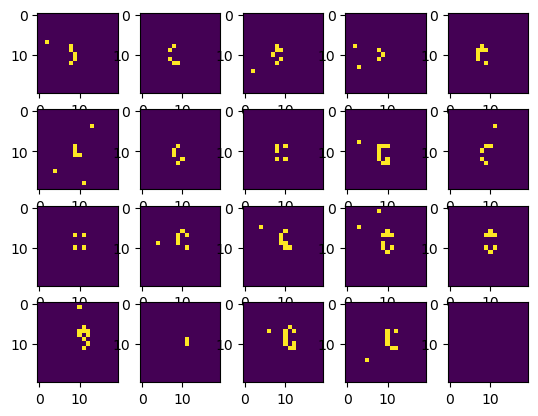

In [236]:
fig, ax = plt.subplots(4, 5)
for j in range(4):
    for i in range(5):        
        ax[j, i].imshow(sol[i, j])

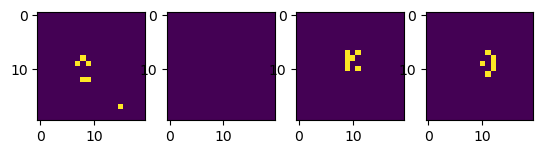

In [244]:
fig, ax = plt.subplots(1, 4)
ax = ax.flatten()

for j in range(4):
    stream = open('solution.yaml', 'r')
    arr = [*(safe_load(stream)[6*N_ions+j]['solution']['variables'].values())]
    sol[0, j] = np.array(arr).reshape(H, V)
    stream.close()
    
for j in range(4):
    ax[j].imshow(sol[0,j])


In [247]:
np.sum(sol[0,3])

6.0

# Rses ful

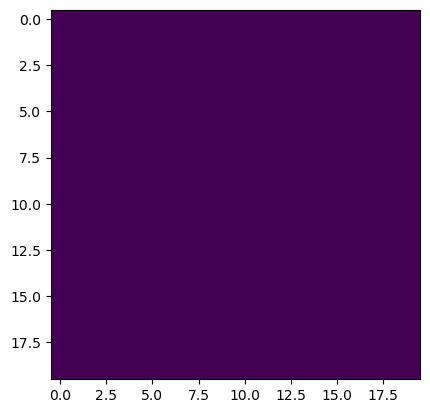

In [228]:

stream = open('solution.yaml', 'r')
arr = [*(safe_load(stream)[4*N_ions+3]['solution']['variables'].values())]
sol[0, 0] = np.array(arr).reshape(H, V)
plt.imshow(sol[0,0])

In [233]:
np.sum(crop(sol[0][0]))/81

0.0

In [229]:
abs(np.sum(crop(sol[0][0]))/81-0.5)

0.5

In [216]:
abs((np.sum(crop(sol[i][j]))/81)-0.5)>=trh

True

In [224]:
range(4,N_img)[0]

4

In [ ]:
print()

In [248]:
N_img = 50
N_ions = 4
H = 20
V = 20
trh = 1
ions = []
sol = np.zeros((N_img, N_ions, H, V))
for i in tqdm(range(4,N_img)):
    print(N_img)
    tmp = []
    for j in range(N_ions):
        stream = open('solution.yaml', 'r')
        arr = [*(safe_load(stream)[i*N_ions+j]['solution']['variables'].values())]
        sol[i, j] = np.array(arr).reshape(H, V)
        stream.close()
        delta = np.sum(crop(sol[i][j]))
        if delta >=trh:
            tmp.append((1, delta))
        else:
            tmp.append((0, delta))
    print(tmp)
    ions.append(tmp)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

50


  2%|█▊                                                                                 | 1/46 [00:39<29:20, 39.12s/it]

[(1, 7.0), (1, 5.0), (1, 7.0), (0, 0.0)]
50


  4%|███▌                                                                               | 2/46 [01:15<27:40, 37.73s/it]

[(1, 5.0), (0, 0.0), (1, 7.0), (1, 6.0)]
50


  7%|█████▍                                                                             | 3/46 [02:06<31:13, 43.57s/it]

[(1, 5.0), (0, 0.0), (1, 7.0), (1, 6.0)]
50


  9%|███████▏                                                                           | 4/46 [02:54<31:46, 45.40s/it]

[(1, 3.0), (1, 6.0), (1, 5.0), (0, 0.0)]
50


 11%|█████████                                                                          | 5/46 [03:36<30:09, 44.13s/it]

[(1, 4.0), (1, 2.0), (1, 7.0), (0, 0.0)]
50


 13%|██████████▊                                                                        | 6/46 [04:30<31:39, 47.49s/it]

[(1, 7.0), (0, 0.0), (0, 0.0), (0, 0.0)]
50


 15%|████████████▋                                                                      | 7/46 [05:12<29:38, 45.60s/it]

[(1, 8.0), (1, 9.0), (0, 0.0), (0, 0.0)]
50


 17%|██████████████▍                                                                    | 8/46 [05:58<29:01, 45.84s/it]

[(1, 4.0), (0, 0.0), (0, 0.0), (1, 5.0)]
50


 20%|████████████████▏                                                                  | 9/46 [06:47<28:55, 46.91s/it]

[(1, 3.0), (1, 5.0), (1, 5.0), (1, 6.0)]
50


 22%|█████████████████▊                                                                | 10/46 [07:26<26:41, 44.49s/it]

[(1, 7.0), (1, 4.0), (0, 0.0), (1, 6.0)]
50


 24%|███████████████████▌                                                              | 11/46 [08:16<26:53, 46.11s/it]

[(0, 0.0), (1, 6.0), (1, 5.0), (1, 6.0)]
50


 26%|█████████████████████▍                                                            | 12/46 [09:01<25:51, 45.62s/it]

[(1, 7.0), (1, 4.0), (1, 5.0), (1, 5.0)]
50


 28%|███████████████████████▏                                                          | 13/46 [09:42<24:21, 44.30s/it]

[(1, 2.0), (1, 1.0), (1, 8.0), (1, 5.0)]
50


 30%|████████████████████████▉                                                         | 14/46 [10:38<25:29, 47.80s/it]

[(1, 7.0), (1, 8.0), (1, 7.0), (1, 9.0)]
50


 33%|██████████████████████████▋                                                       | 15/46 [11:25<24:34, 47.57s/it]

[(1, 5.0), (1, 2.0), (1, 7.0), (1, 7.0)]
50


 35%|████████████████████████████▌                                                     | 16/46 [12:15<24:13, 48.44s/it]

[(1, 6.0), (1, 7.0), (0, 0.0), (1, 7.0)]
50


 37%|██████████████████████████████▎                                                   | 17/46 [12:59<22:43, 47.01s/it]

[(0, 0.0), (1, 5.0), (1, 5.0), (1, 9.0)]
50


 39%|████████████████████████████████                                                  | 18/46 [13:40<21:04, 45.15s/it]

[(1, 5.0), (1, 5.0), (1, 6.0), (1, 7.0)]
50


 41%|█████████████████████████████████▊                                                | 19/46 [14:29<20:51, 46.34s/it]

[(1, 1.0), (1, 6.0), (1, 4.0), (0, 0.0)]
50


 43%|███████████████████████████████████▋                                              | 20/46 [15:07<18:59, 43.82s/it]

[(1, 2.0), (1, 5.0), (1, 6.0), (1, 2.0)]
50


 46%|█████████████████████████████████████▍                                            | 21/46 [15:48<17:54, 42.96s/it]

[(1, 9.0), (1, 3.0), (1, 8.0), (1, 8.0)]
50


 48%|███████████████████████████████████████▏                                          | 22/46 [16:35<17:44, 44.37s/it]

[(1, 6.0), (1, 5.0), (1, 2.0), (1, 12.0)]
50


 50%|█████████████████████████████████████████                                         | 23/46 [17:15<16:24, 42.82s/it]

[(1, 6.0), (1, 9.0), (0, 0.0), (1, 5.0)]
50


 52%|██████████████████████████████████████████▊                                       | 24/46 [18:01<16:03, 43.78s/it]

[(1, 3.0), (1, 5.0), (1, 2.0), (0, 0.0)]
50


 54%|████████████████████████████████████████████▌                                     | 25/46 [18:57<16:36, 47.46s/it]

[(1, 5.0), (1, 4.0), (1, 7.0), (1, 7.0)]
50


 57%|██████████████████████████████████████████████▎                                   | 26/46 [19:40<15:23, 46.18s/it]

[(1, 4.0), (1, 8.0), (0, 0.0), (0, 0.0)]
50


 59%|████████████████████████████████████████████████▏                                 | 27/46 [20:28<14:51, 46.90s/it]

[(1, 7.0), (1, 7.0), (0, 0.0), (1, 7.0)]
50


 61%|█████████████████████████████████████████████████▉                                | 28/46 [21:08<13:24, 44.70s/it]

[(1, 6.0), (0, 0.0), (1, 5.0), (0, 0.0)]
50


 63%|███████████████████████████████████████████████████▋                              | 29/46 [21:51<12:29, 44.10s/it]

[(1, 5.0), (1, 8.0), (1, 9.0), (1, 8.0)]
50


 65%|█████████████████████████████████████████████████████▍                            | 30/46 [22:37<11:57, 44.87s/it]

[(1, 7.0), (1, 8.0), (0, 0.0), (1, 7.0)]
50


 67%|███████████████████████████████████████████████████████▎                          | 31/46 [23:16<10:46, 43.12s/it]

[(0, 0.0), (1, 4.0), (1, 7.0), (1, 8.0)]
50


 70%|█████████████████████████████████████████████████████████                         | 32/46 [24:02<10:15, 43.97s/it]

[(1, 6.0), (1, 4.0), (1, 6.0), (1, 6.0)]
50


 72%|██████████████████████████████████████████████████████████▊                       | 33/46 [24:46<09:31, 43.93s/it]

[(1, 6.0), (1, 1.0), (1, 6.0), (1, 5.0)]
50


 74%|████████████████████████████████████████████████████████████▌                     | 34/46 [25:25<08:29, 42.46s/it]

[(1, 5.0), (1, 8.0), (0, 0.0), (1, 6.0)]
50


 76%|██████████████████████████████████████████████████████████████▍                   | 35/46 [26:12<08:02, 43.86s/it]

[(1, 7.0), (1, 6.0), (0, 0.0), (1, 8.0)]
50


 78%|████████████████████████████████████████████████████████████████▏                 | 36/46 [26:54<07:11, 43.17s/it]

[(0, 0.0), (1, 7.0), (0, 0.0), (1, 8.0)]
50


 80%|█████████████████████████████████████████████████████████████████▉                | 37/46 [27:33<06:18, 42.04s/it]

[(1, 7.0), (1, 6.0), (1, 8.0), (1, 8.0)]
50


 83%|███████████████████████████████████████████████████████████████████▋              | 38/46 [28:22<05:52, 44.10s/it]

[(1, 5.0), (0, 0.0), (1, 5.0), (1, 8.0)]
50


 85%|█████████████████████████████████████████████████████████████████████▌            | 39/46 [29:04<05:03, 43.33s/it]

[(0, 0.0), (1, 6.0), (1, 6.0), (1, 2.0)]
50


 87%|███████████████████████████████████████████████████████████████████████▎          | 40/46 [29:47<04:18, 43.16s/it]

[(1, 6.0), (1, 3.0), (1, 6.0), (1, 9.0)]
50


 89%|█████████████████████████████████████████████████████████████████████████         | 41/46 [30:41<03:52, 46.54s/it]

[(0, 0.0), (0, 0.0), (1, 6.0), (0, 0.0)]
50


 91%|██████████████████████████████████████████████████████████████████████████▊       | 42/46 [31:19<02:56, 44.06s/it]

[(1, 6.0), (1, 6.0), (1, 4.0), (1, 7.0)]
50


 93%|████████████████████████████████████████████████████████████████████████████▋     | 43/46 [32:05<02:14, 44.70s/it]

[(1, 7.0), (1, 4.0), (1, 6.0), (1, 8.0)]
50


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 44/46 [32:49<01:28, 44.40s/it]

[(1, 7.0), (1, 4.0), (1, 6.0), (1, 8.0)]
50


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 45/46 [33:28<00:42, 42.59s/it]

[(1, 6.0), (1, 3.0), (1, 7.0), (1, 6.0)]
50


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [34:16<00:00, 44.72s/it]

[(0, 0.0), (1, 7.0), (1, 6.0), (1, 7.0)]


0.8271604938271605

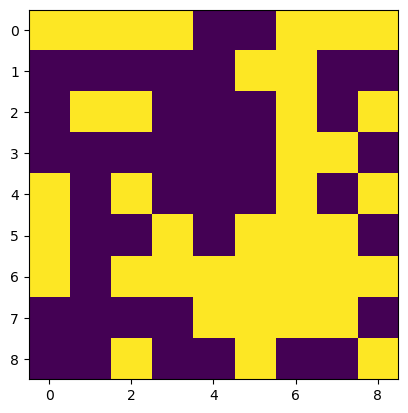

In [203]:
def crop(im):
    return im[6:15, 6:15]
plt.imshow(crop(sol[0][3]))
np.sum(crop(sol[4][0]))/81

In [142]:
np.sum(sol[0][1])/196

0.3979591836734694

In [107]:
data = sol

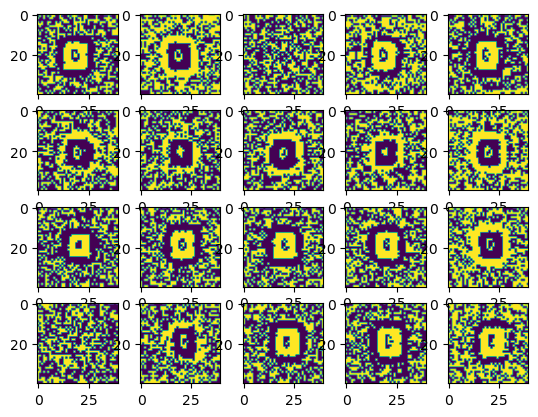

In [88]:
fig, ax = plt.subplots(4, 5)
for j in range(4):
    for i in range(5):        
        ax[j, i].imshow(sol[i, j])

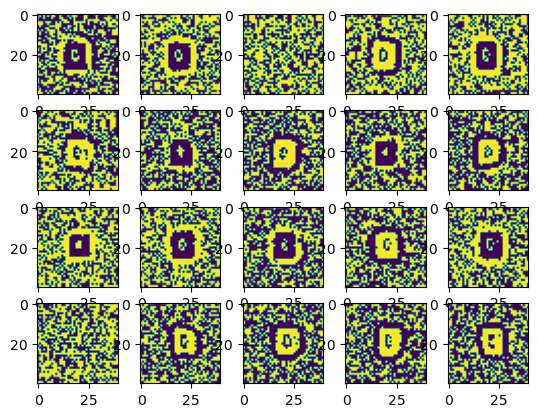

In [80]:
fig, ax = plt.subplots(4, 5)
for j in range(4):
    for i in range(5):        
        ax[j, i].imshow(sol[i, j])

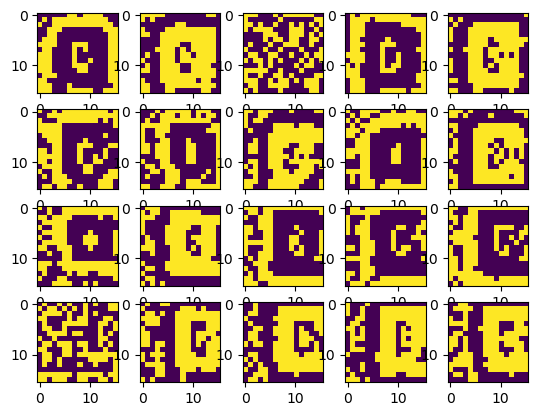

In [69]:
fig, ax = plt.subplots(4, 5)
for j in range(4):
    for i in range(5):        
        ax[j, i].imshow(sol[i, j])

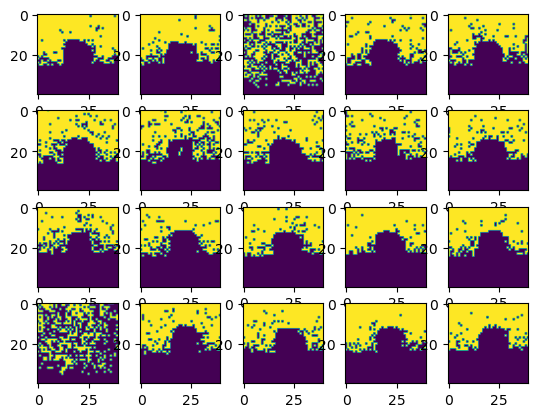

In [44]:
fig, ax = plt.subplots(4, 5)
for j in range(4):
    for i in range(5):        
        ax[j, i].imshow(sol[i, j])

In [131]:
shape(ion_list[0][3])

(280, 280)

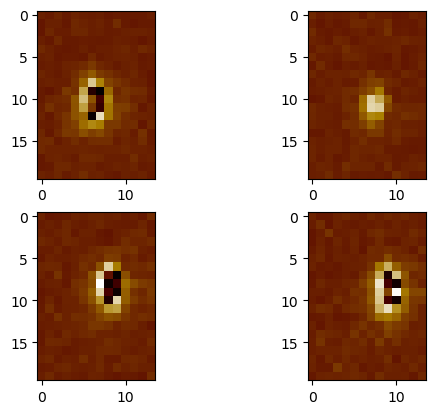

In [80]:
fig, ax = subplots(2,2)
ax = ax.flatten()

for j in range(4):
    ax[j].imshow(ion_list[1][j])

In [22]:
ion_1 = ion[10:30,22:36,:]

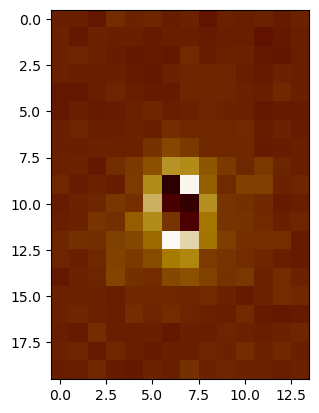

In [23]:
plt.imshow(ion_1, interpolation='nearest')
plt.show()

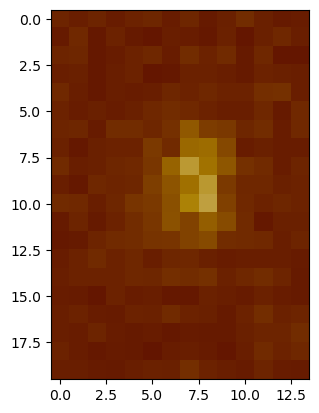

In [27]:
ion_2 = ion[50:70,22:36,:]
plt.imshow(ion_2, interpolation='nearest')
plt.show()

# Classical

In [ ]:
scarlet = cv2.imread("photos/4.png")
image=cv2.cvtColor(scarlet,cv2.COLOR_BGR2GRAY)
se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, se)
out_gray=cv2.divide(image, bg, scale=255)
out_binary=cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU )[1] 

# cv2.imshow('binary', out_binary)  
cv2.imwrite('binary1.png',out_binary)

# cv2.imshow('gray', out_gray)  
cv2.imwrite('gray1.png',out_gray)